# Initial Conditions

In this Notebook, binary files for the initial conditions of my model study for temperature and salinity are created based on data from the World Ocean Atlas 2023.

###  Import Packages

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import gsw as gsw
import matplotlib as plt

### Load Data

Load WOA Netcdf files for temperature and (practical) salinity, select objectively analyzed means and merge both variables into one xarray dataset.

In [80]:
datapath = "/albedo/home/maschr005/data/"
filename_T = "woa23_B5C2_t06_04.nc"
filename_S = "woa23_B5C2_s06_04.nc"

# load datasets
ds_T = xr.open_dataset(datapath+filename_T, decode_cf=False)
ds_S = xr.open_dataset(datapath+filename_S, decode_cf=False)

# merge objectively analyzed means of T and S into one dataset
ds = xr.merge([ds_T[["t_an"]], ds_S[["s_an"]]], compat = "identical")
# rename variables
ds = ds.rename({"t_an": "t", "s_an":"SP"})

### Region of Interest

We select our region of interest based on the occurence of "sea ice"-supercooling as found by Haumann et al. (2020).

In [81]:
# crop to region of interest
lat_slice = slice(-63,-55)
lon_slice = slice(0,8)
ds = ds.sel(lat = lat_slice, lon = lon_slice)

### Complete Dataset

Calculate Sea Pressure, Absolute Salinity, Potential Temperature and Conservative Temperature using the gsw toolbox.

In [82]:
# calculate SEA PRESSURE from depth
ds["p"] = gsw.conversions.p_from_z(-ds.depth,ds.lat)
# delete inherited attributes
ds["p"].attrs = {}
# assign correct attributes
ds["p"].attrs.update({
    "standard_name": "sea pressure",
    "units": "dbar",
})

# calculate ABSOLUTE SALINITY
ds["SA"] = gsw.conversions.SA_from_SP(ds["SP"], ds["p"], ds.lon, ds.lat)
# delete inherited attributes
ds["SA"].attrs = {}
# assign correct attributes
ds["SA"].attrs.update({
    "standard_name": "absolute salinity",
    "units": "g/kg",
})

# calculate POTENTIAL TEMPERATURE with surface reference pressure
ds["pt"] = gsw.conversions.pt0_from_t(ds["SA"], ds["t"], ds["p"])
# delete inherited attributes
ds["pt"].attrs = {}
# assign correct attributes
ds["pt"].attrs.update({
    "standard_name": "potential temperature p_ref = 0 dbar",
    "long_name": "potential temperature referenced to a sea pressure of zero dbar",
    "units": "degrees_celsius",
})

# calculate CONSERVATIVE TEMPERATURE
ds["ct"] = gsw.conversions.CT_from_pt(ds["SA"], ds["pt"])
# delete inherited attributes
ds["ct"].attrs = {}
# assign correct attributes
ds["ct"].attrs.update({
    "standard_name": "conservative temperature p_ref = 0 dbar",
    "units": "degrees_celsius",
})

# reorder variables
ds = ds[["p", "t", "pt", "ct", "SP", "SA"]]

### Crop in vertical dimension (depth)

We want to study the water column from the surface down to the upper Circum Polar Deep Water. Therefore, we look for depth of the upper circumpolar deep water. Subsequently, the dataset is cropped to this depth.

#### Find depth of Upper Circumpolar Deep Water

425.0


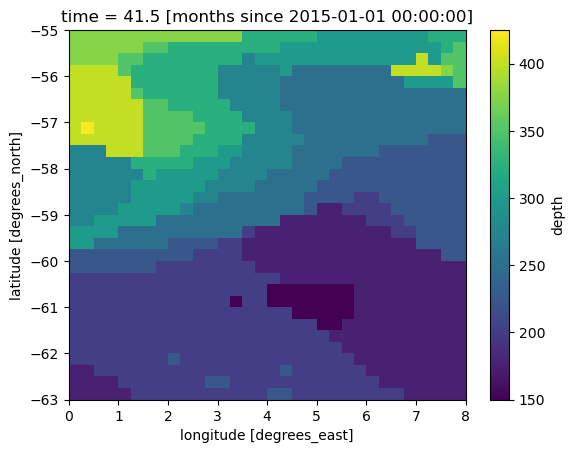

In [83]:
# find depth of temperature maximum
depth_Tmax = ds.t.idxmax(dim = "depth", keep_attrs=False)
depth_Tmax.plot()
print(np.max(depth_Tmax.values))

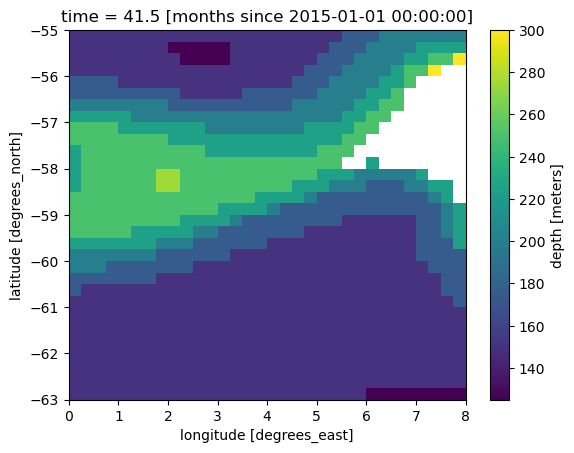

In [103]:
# find top of uCDW
cdw_minT = 0.5
cdw_depths = ds.depth.where(ds.t>cdw_minT)
cdw_depth_min = cdw_depths.min(dim = "depth")
cdw_depth_min.plot()

#### Crop to maximum depth

In [62]:
# maximum depth
max_depth = 300
ds = ds.sel(depth = slice(0,max_depth))

### Crop to point location

In [ ]:
# select chosen location
lat_loc = -58.5
lon_loc = 5.5
ds_loc = ds.sel(lat = lat_loc, lon = lon_loc, method = "nearest")

#### Interpolate to grid structure?

In [ ]:
# grid
cell_size = 0.5 # [deg]

# vertical structure?


### Write binaries

See https://xmitgcm.readthedocs.io/en/latest/demo_writing_binary_file.html